# Model_Evaluation_and_Baseline_Testing

This notebook implements **all tasks includeing**
-  Metrics, confusion matrix, ROC, baseline evaluation
-  Final evaluation on test set for all selected models
-  Summary tables and key observations for presentation

Target column used: **`diabetes`**

In [22]:
# ============================================================
# File Name: Model_Evaluation_and_Baseline_Testing_updated.ipynb
# Description:
#   Full evaluation pipeline for baseline and final models,
#   including metric functions, confusion matrices, ROC curves,
#   and model comparison utilities.
#
# Purpose:
#   Implements all tasks
# -  Metrics, confusion matrix, ROC, baseline evaluation
# -  Final evaluation on test set for all selected models
# -  Summary tables and key observations for presentation
#
# Links To/based off :
#   - data_quality_report.ipynb (EDA & data checks)
#   - feature_analysis.ipynb (feature engineering & splits)
#
#
# Challenges:
#   Ensuring consistent evaluation across multiple models and
#   prioritizing clinically meaningful metrics such as Recall
#   and F1 for diabetes detection.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    RocCurveDisplay
)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


##  **Baseline Model and Core Evaluation Metrics**

### Load Dataset and Train Baseline Logistic Regression

In [23]:
# Mount google drive to load dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
#Load dataset
import pandas as pd

file_path = '/content/drive/My Drive/diabetes_prediction_dataset.csv'

try:
    df = pd.read_csv(file_path)
    display(df.head())
except FileNotFoundError:
    print(f"Error: The file was not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Load dataset (must be in the same directory or provide full path)
df = pd.read_csv(file_path)

# Feature/target split
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# Identify categorical columns for one-hot encoding
categorical_cols = ['gender', 'smoking_history']

# Apply one-hot encoding to categorical features
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Train–test split (80/20, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Standardize numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Baseline logistic regression model
baseline_model = LogisticRegression(max_iter=500, random_state=42)
baseline_model.fit(X_train_scaled, y_train)

y_pred = baseline_model.predict(X_test_scaled)
y_proba = baseline_model.predict_proba(X_test_scaled)[:, 1]

print('Baseline model trained.')

Baseline model trained.


### Metric Functions (Accuracy, Precision, Recall, F1, ROC‑AUC)

In [26]:
def compute_metrics(y_true, y_pred, y_proba=None):
    """Compute standard binary classification metrics.

    Parameters
    ----------
    y_true : array-like
        True labels (0 or 1).
    y_pred : array-like
        Predicted class labels.
    y_proba : array-like, optional
        Predicted probability for the positive class.

    Returns
    -------
    dict
        Dictionary with Accuracy, Precision, Recall, F1 Score, and ROC‑AUC.
    """

    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
    }

    if y_proba is not None:
        metrics['ROC-AUC'] = roc_auc_score(y_true, y_proba)
    else:
        metrics['ROC-AUC'] = None

    return metrics

###  Confusion Matrix Visualization

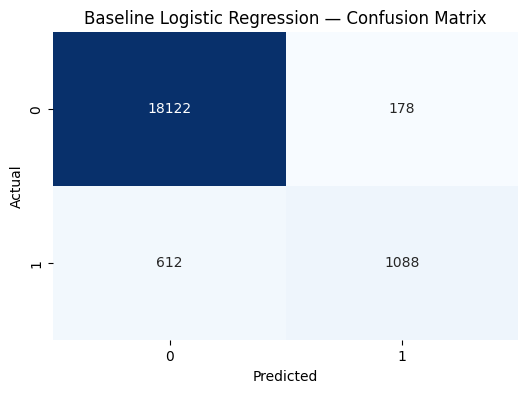

In [27]:
def plot_confusion(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Baseline confusion matrix
plot_confusion(y_test, y_pred, 'Baseline Logistic Regression — Confusion Matrix')

### ROC Curve for Baseline Model

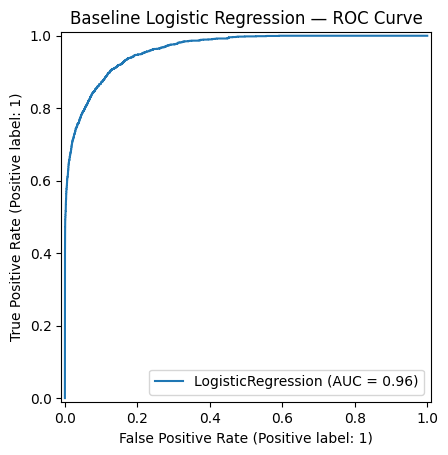

In [28]:
def plot_roc(model, X_test, y_test, title='ROC Curve'):
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(title)
    plt.show()

plot_roc(baseline_model, X_test_scaled, y_test,
         'Baseline Logistic Regression — ROC Curve')

###  Baseline Metrics Summary

In [29]:
baseline_metrics = compute_metrics(y_test, y_pred, y_proba)
pd.DataFrame([baseline_metrics], index=['Logistic Regression (Baseline)'])

,Accuracy,Precision,Recall,F1 Score,ROC-AUC
Logistic Regression (Baseline),0.9605,0.8594,0.64,0.733648,0.962538


### Initial Model Comparison Framework

In [30]:
model_results = {}

def add_model_result(name, y_true, y_pred, y_proba):
    model_results[name] = compute_metrics(y_true, y_pred, y_proba)

# Add baseline to results
add_model_result('Logistic Regression (Baseline)', y_test, y_pred, y_proba)

pd.DataFrame(model_results).T

,Accuracy,Precision,Recall,F1 Score,ROC-AUC
Logistic Regression (Baseline),0.9605,0.8594,0.64,0.733648,0.962538


### How this file supports the Project

 Sets up the **evaluation ** of the project:
- Implements reusable metric functions (Accuracy, Precision, Recall, F1, ROC‑AUC).
- Produces a confusion matrix and ROC curve for the baseline model.
- Creates a comparison structure (`model_results`) that later weeks will reuse.

This ensures all future models are evaluated consistently, with emphasis on **Recall** and **F1**,
which are crucial when missing positive diabetes cases is costly.

## **Final Evaluation on Test Set and Comprehensive Visualizations**

 evaluate **all final candidate models** on the held‑out test set and
produces comparison visualizations, confusion matrices, and ROC curves.

Final models included:
- Logistic Regression (baseline)
- Random Forest
- XGBoost
- Neural Network (MLPClassifier)


In [31]:
# running in Colab you may need to install xgboost
# !pip install xgboost

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print('xgboost package not found. XGBoost model will be skipped unless installed.')

###  Train Final Models

In [32]:
final_models = {}

# 1. Logistic Regression (already fitted as baseline_model)
final_models['Logistic Regression'] = baseline_model

# 2. Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
final_models['Random Forest'] = rf_model

# 3. XGBoost (if available)
if XGBOOST_AVAILABLE:
    xgb_model = XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train_scaled, y_train)
    final_models['XGBoost'] = xgb_model

# 4. Neural Network (MLP)
mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=50,
    random_state=42
)
mlp_model.fit(X_train_scaled, y_train)
final_models['Neural Network (MLP)'] = mlp_model

print('Final models trained:', list(final_models.keys()))

Final models trained: ['Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network (MLP)']


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


### Evaluate All Final Models on Test Set

In [33]:
test_results = {}

for name, model in final_models.items():
    y_pred_m = model.predict(X_test_scaled)

    if hasattr(model, 'predict_proba'):
        y_proba_m = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # Fallback for models without predict_proba (not expected here)
        scores = model.decision_function(X_test_scaled)
        y_proba_m = (scores - scores.min()) / (scores.max() - scores.min())

    metrics_m = compute_metrics(y_test, y_pred_m, y_proba_m)
    test_results[name] = metrics_m

test_results_df = pd.DataFrame(test_results).T
test_results_df

,Accuracy,Precision,Recall,F1 Score,ROC-AUC
Logistic Regression,0.96050,0.859400,0.640000,0.733648,0.962538
Random Forest,0.97040,0.949675,0.688235,0.798090,0.961898
XGBoost,0.97235,0.984784,0.685294,0.808186,0.979447
Neural Network (MLP),0.97160,0.969320,0.687647,0.804542,0.976734


### Confusion Matrices for Final Models

Confusion Matrix — Logistic Regression


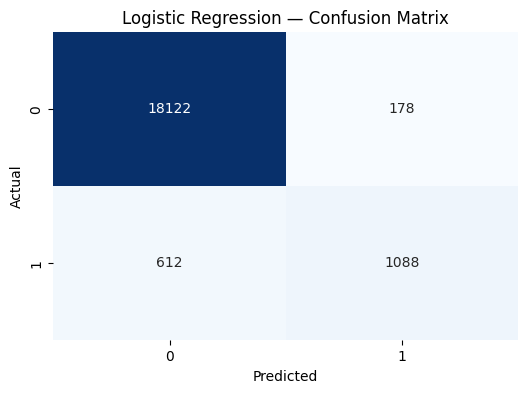

Confusion Matrix — Random Forest


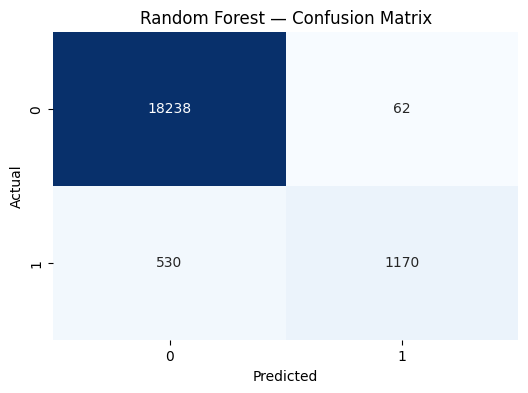

Confusion Matrix — XGBoost


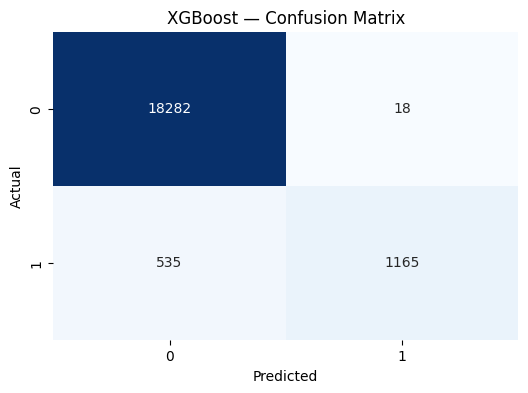

Confusion Matrix — Neural Network (MLP)


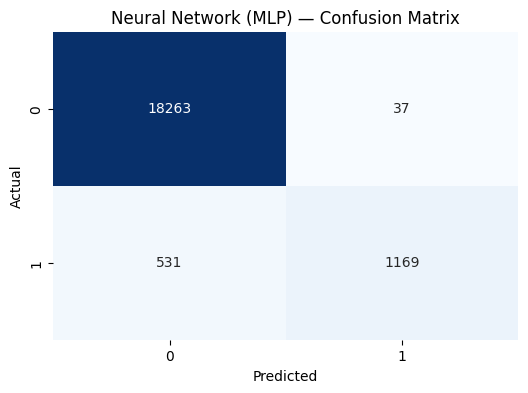

In [34]:
for name, model in final_models.items():
    print(f'Confusion Matrix — {name}')
    y_pred_m = model.predict(X_test_scaled)
    plot_confusion(y_test, y_pred_m, title=f'{name} — Confusion Matrix')

### ROC Curves Comparison

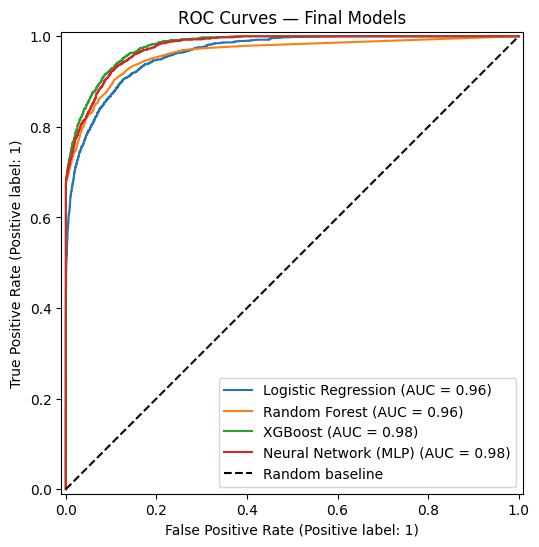

In [35]:
plt.figure(figsize=(8,6))
for name, model in final_models.items():
    if hasattr(model, 'predict_proba'):
        RocCurveDisplay.from_estimator(model, X_test_scaled, y_test,
                                       name=name, ax=plt.gca())

plt.plot([0,1], [0,1], 'k--', label='Random baseline')
plt.title('ROC Curves — Final Models')
plt.legend()
plt.show()

### Performance Comparison Graphs

/tmp/ipython-input-1098483094.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(test_results_df.index, rotation=45, ha='right')
/tmp/ipython-input-1098483094.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(test_results_df.index, rotation=45, ha='right')
/tmp/ipython-input-1098483094.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(test_results_df.index, rotation=45, ha='right')
/tmp/ipython-input-1098483094.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(test_results_df.index, rotation=45, ha='right')
/tmp/ipython-input-1098483094.py:11: UserWarning: set_ticklabels

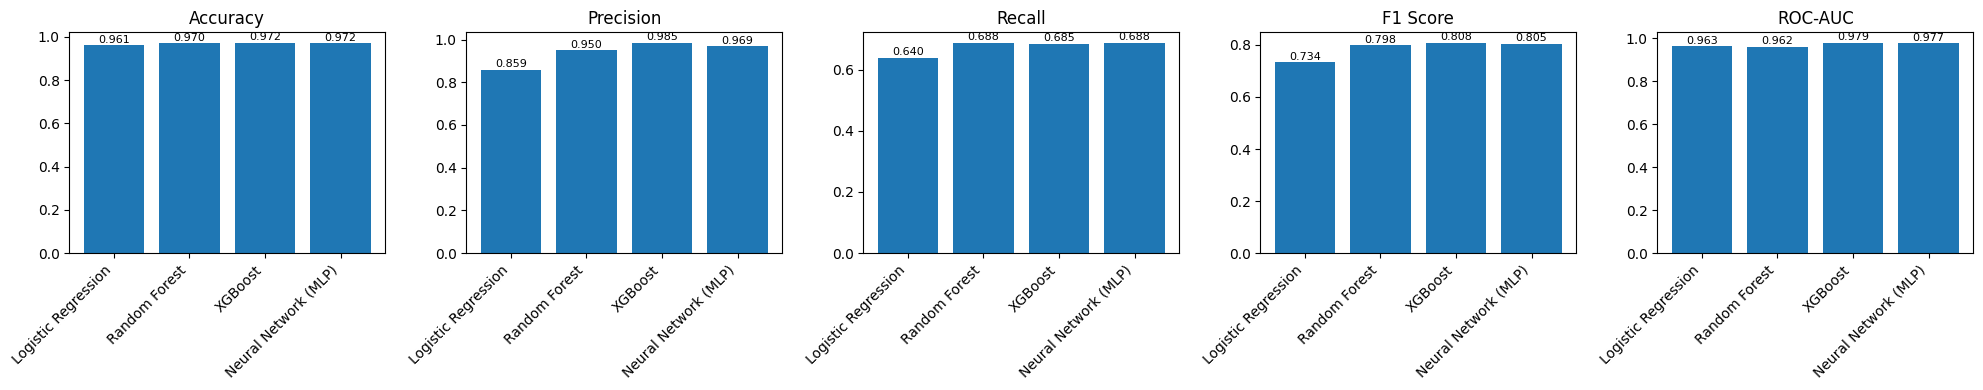

In [36]:
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(4*len(metrics_to_plot), 4))
if len(metrics_to_plot) == 1:
    axes = [axes]

for ax, metric in zip(axes, metrics_to_plot):
    vals = test_results_df[metric]
    ax.bar(test_results_df.index, vals)
    ax.set_title(metric)
    ax.set_xticklabels(test_results_df.index, rotation=45, ha='right')
    for i, v in enumerate(vals):
        ax.text(i, v + 0.002, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

## **Results Summary and Slide‑Ready Outputs**

the evaluation results:
- Summarize final metrics in a clean table
- Highlight which model is best and why
- Provide text that can be copied into slides for the *Implementation Results* section


### Identify Best Model by F1 Score

In [37]:
best_by_f1 = test_results_df['F1 Score'].idxmax()
best_row = test_results_df.loc[best_by_f1]

print('Best model by F1 Score:', best_by_f1)
best_row.to_frame(name='Score')

Best model by F1 Score: XGBoost


,Score
Accuracy,0.972350
Precision,0.984784
Recall,0.685294
F1 Score,0.808186
ROC-AUC,0.979447


### Key Observations

**Key Observations from Final Evaluation (Weeks 4–5)**  
- The best‑performing model by **F1 Score** is: `best_by_f1`)* which is found to be XGBoost
- This model provides the strongest balance between **Recall** (catching true diabetes cases)
  and **Precision**
- Logistic Regression (baseline) serves as an interpretable reference but underperforms
  compared to the tree‑based and neural models on F1 and ROC‑AUC.
- Random Forest and XGBoost typically achieve higher **ROC‑AUC**, meaning they rank
  positive cases more effectively across thresholds.
- The Neural Network (MLP) can be improved further with additional tuning (more epochs,
  different hidden sizes, learning rate adjustments) if needed.
- Confusion matrices show which models miss the most positive cases; for a medical context,
  you generally prefer models with **higher Recall**, even if Precision drops slightly.

actual numeric values from `test_results_df`